In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
import cvxpy as cp
from pytope import Polytope
from matplotlib.animation import FuncAnimation
from scipy.linalg import sqrtm, inv
from matplotlib.patches import Ellipse

In [2]:
data_id = "08"
track_id  = 318

background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"

tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == track_id]

xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
acc_vals= np.vstack((xAcc,yAcc))
N_Sam = acc_vals.shape[1]

xPos = filtered_data["xCenter"].to_numpy()
yPos = filtered_data["yCenter"].to_numpy()
position_vals = np.vstack((xPos,yPos))

SV_x = xPos
SV_y = yPos

xVel = filtered_data["xVelocity"].to_numpy()
yVel = filtered_data["yVelocity"].to_numpy()
velocity_vals = np.vstack((xVel,yVel))

yaw = filtered_data["heading"].to_numpy()

recordingMeta = pd.read_csv(recordingMeta_filepath)
orthoPxToMeter = recordingMeta["orthoPxToMeter"].iloc[0]

vehicle_data = pd.read_csv(tracksMeta_filepath)
filtered_vehicle_param = vehicle_data[vehicle_data['trackId'] == track_id]
sv_width = filtered_vehicle_param["width"]
sv_length = filtered_vehicle_param["length"]
sv_lifetime = filtered_vehicle_param["numFrames"].to_numpy().item()

In [3]:
def gen_drive_area(vertices):
    Drive_Area = Polytope(vertices*(0.00814636091724916*12))
    Drive_Area_visual = Polytope(vertices)
    A_road = Drive_Area.A
    b_road = Drive_Area.b
    return Drive_Area, Drive_Area_visual, A_road, b_road

road_vertices = np.array([
    # [294, -59],
    # [590, -388],
    # [731, -221],
    # [473, 88],

    # [258, -56],
    # [799, -671],
    # [829, -643],
    # [281, -45]

    [297, -24],
    [847, -623],
    [869, -607],
    [332, -7]


])

not_road_vertices = [
    # np.array([
    #     [303, -30],
    #     [548, -290],
    #     [701, -151],
    #     [473, 88]
    #  ]),
    np.array([
    [0, 1],
    [1, 1],
    [1,  0],
    [0, 0]
    ]),
]

Drive_Area, Drive_Area_visual, A_road, b_road = gen_drive_area(road_vertices)
not_Drive_Area = []
not_Drive_Area_visual = []
not_A_road = []
not_b_road = []
for i in range(len(not_road_vertices)):
    tmp1, tmp2, tmp3, tmp4 = gen_drive_area(not_road_vertices[i])
    not_Drive_Area.append(tmp1)
    not_Drive_Area_visual.append(tmp2)
    not_A_road.append(tmp3)
    not_b_road.append(tmp4)

In [4]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}
location_id = "2"
scale_down_factor = image_param["datasets"]["ind"]["scale_down_factor"]
x_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][0]/scale_down_factor
x_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][1]/scale_down_factor
y_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][0]/scale_down_factor
y_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][1]/scale_down_factor
x_lim_0 = 200
x_lim_1 = 900
y_lim_0 = 700
y_lim_1 = 0
image_to_real = orthoPxToMeter*scale_down_factor
real_to_image = 1/image_to_real

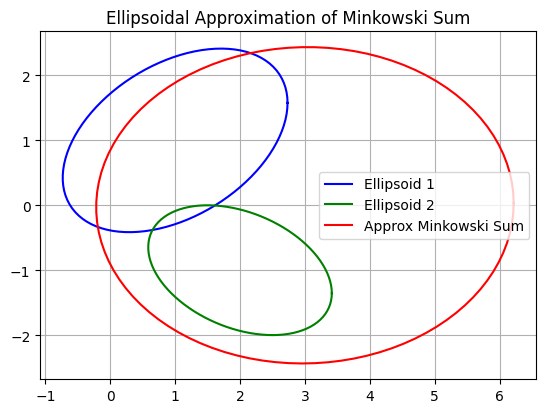

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ellipsoid(q, Q, ax, color='b', label=None):
    # Draws 2D ellipsoid defined by center q and shape matrix Q
    theta = np.linspace(0, 2*np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])  # shape (2, N)
    ellipse = q[:, None] + Q @ unit_circle
    ax.plot(ellipse[0, :], ellipse[1, :], color=color, label=label)

def Minksum_EA(q1, Q1, q2, Q2, L):
    q = q1 + q2
    Q_Left  = np.sqrt(L.T @ Q1 @ L) + np.sqrt(L.T @ Q2 @ L)
    Q_Right = Q1 / np.sqrt(L.T @ Q1 @ L) + Q2 / np.sqrt(L.T @ Q2 @ L)
    Q = Q_Left * Q_Right
    return q, Q

def test_minksum():
    # Define 2D ellipsoids
    q1 = np.array([1.0, 1.0])
    Q1 = np.array([[3.0, 1.0],
                   [1.0, 2.0]])
    
    q2 = np.array([2.0, -1.0])
    Q2 = np.array([[2.0, -0.5],
                   [-0.5, 1.0]])

    # Choose direction L (can be any nonzero vector, typically unit vector)
    L = np.array([[1.0], [1.0]])  # 2D column vector

    # Run Minkowski sum ellipsoidal approximation
    q_sum, Q_sum = Minksum_EA(q1, Q1, q2, Q2, L)

    # Plot
    fig, ax = plt.subplots()
    plot_ellipsoid(q1, np.linalg.cholesky(Q1), ax, color='blue', label='Ellipsoid 1')
    plot_ellipsoid(q2, np.linalg.cholesky(Q2), ax, color='green', label='Ellipsoid 2')
    plot_ellipsoid(q_sum, np.linalg.cholesky(Q_sum), ax, color='red', label='Approx Minkowski Sum')
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    ax.set_title("Ellipsoidal Approximation of Minkowski Sum")
    plt.show()

test_minksum()


In [6]:
class el_estimation_OR():
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.Q8 = Param["Q8"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.not_A_road = Param["not_A_road"]
        self.not_b_road = Param["not_b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        self.MPC = self.MPCFormulation()
        self.sample = np.zeros((2, 1))
        self.L_Occ = np.array([1, 1]).reshape(2, 1)
        self.L_State = np.array([1, 1, 1, 1]).reshape(4, 1)

        A_init = np.array([[1, 0], 
                    [0, 1]])
        b_init = np.array([[0], 
                    [0]]) 
        c_init = b_init.T@b_init-1
        u_init = np.array([0.1,0.1])
        B_pre, b_tilde_pre = self.opti_SDP_lemma(A_init,b_init,c_init,u_init)
        self.A_pre = sqrtm(B_pre)
        self.b_pre = np.linalg.inv(self.A_pre)@b_tilde_pre

    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        Qr_inv, qr , Q_visual, q_visual = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k= self.MPC(Qr_inv, qr, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Qr_inv, qr, Q_visual, q_visual
    
    def Minksum_EA(self, q1, Q1, q2, Q2, L):
        q       = q1 + q2
        Q_Left  = np.sqrt(L.T@Q1@L) + np.sqrt(L.T@Q2@L)
        Q_Right = Q1/np.sqrt(L.T@Q1@L) + Q2/np.sqrt(L.T@Q2@L)
        Q       = Q_Left*Q_Right
        
        return q, Q

    def ReachableSet(self, SV_Acc_new, SV_Pos_new, SV_Vel_new):
        A_u, b_u = self.el(SV_Acc_new)
        A_u_inv = np.linalg.inv(A_u)
        Q_robust = A_u_inv @ A_u_inv.T
        q_robust = -A_u_inv @ b_u
        # Q_robust = np.linalg.inv(A_u.T@A_u)

        Q_safedistance = np.diag([self.d_min**2, self.d_min**2])
        Q_measure = np.diag([0.001**2, 0.001**2, 0.001**2, 0.001**2])

        x_init = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]]).reshape(-1, 1)

        A_s = np.array([
            [1, self.T, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, self.T],
            [0, 0, 0, 1]
        ])

        B_s = np.array([
            [0.5 * self.T ** 2, 0],
            [self.T, 0],
            [0, 0.5 * self.T ** 2],
            [0, self.T]
        ])

        du = 0.00001
        N = self.N

        Reachable_Set_q = [x_init]
        Reachable_Set_Q = [Q_measure]
        # with safety margin
        qr = np.zeros((2, N))
        Qr_Inv = np.zeros((2, 2 * N))
        # without safety margin
        q_visual = np.zeros((2, N))
        Q_visual = np.zeros((2, 2 * N))

        for t in range(1, N + 1):
            q_prev = Reachable_Set_q[t - 1]
            Q_prev = Reachable_Set_Q[t - 1]

            q1 = A_s @ q_prev
            Q1 = A_s @ Q_prev @ A_s.T
            q2 = B_s @ q_robust
            Q2 = B_s @ Q_robust @ B_s.T + du * np.eye(4)


            q_combined, Q_combined = self.Minksum_EA(q1, Q1, q2, Q2, self.L_State)
            Reachable_Set_q.append(q_combined)
            Reachable_Set_Q.append(Q_combined)

            q_pos = q_combined[[0, 2], :]
            Q_pos = Q_combined[[0, 2], :][:, [0, 2]]

            q_visual[:, t - 1] = q_pos.flatten()
            Q_visual[:, 2 * (t - 1):2 * t] = np.linalg.inv(Q_pos)

            q_final, Q_final = self.Minksum_EA(q_pos, Q_pos, np.zeros((2, 1)), Q_safedistance, self.L_Occ)

            qr[:, t - 1] = q_final.flatten()
            Qr_Inv[:, 2 * (t - 1):2 * t] = np.linalg.inv(Q_final)

        return Qr_Inv, qr, Q_visual, q_visual


        
    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        Q8 = self.Q8
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        not_A_road = self.not_A_road        #driving not_area.A
        not_b_road = self.not_b_road        #driving not_area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]

        Qr_inv = opti.parameter(2, 2*N)
        qr = opti.parameter(2, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        tmp1 = opti.variable(4,N)
        J = 0
        
        for k in range(N):
            p_point = X[0:2, k + 1]

            Q_k_Inv = Qr_inv[:, 2*k:2*k + 2]
            q_k = qr[:, k]
            opti.subject_to(1 <= (p_point - q_k).T@Q_k_Inv@(p_point - q_k))
            
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)

            opti.subject_to((not_A_road[0]@ca.reshape(p_point,2,1)-not_b_road[0]).T@tmp1[:,k] >= 0.5)#- s1[k])
            opti.subject_to(ca.dot(not_A_road[0].T@tmp1[:,k],not_A_road[0].T@tmp1[:,k])<=1)

        opti.subject_to(opti.bounded(0, tmp1, ca.inf))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J += delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [Qr_inv, qr, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J])
    
    #kinematic unicycle model
    def vehicle_model_1(self, w, delta, eta):
        x     = w[0]
        y     = w[1]
        phi   = w[2]
        v     = w[3]
        a     = w[4]

        x_dot     = v * ca.cos(phi)
        y_dot     = v * ca.sin(phi)
        phi_dot = delta
        v_dot     = a
        a_dot     = eta

        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

    #kinematic bicycle model
    def vehicle_model(self, w, delta, eta): 
        l_f = self.l_f
        l_r = self.l_r
        L = l_f + l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        # phi_dot = w[3] / L * ca.tan(delta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    
    #ackerman steering model
    def vehicle_model_1(self, w, delta, eta):
        l_f = self.l_f 
        l_r = self.l_r  
        W = self.w_veh
        L = l_f + l_r

        R = L / delta
        delta_inner = ca.atan(L / (R - W / 2))
        delta_outer = ca.atan(L / (R + W / 2))
        delta_avg = ca.if_else(ca.fabs(delta) < 1e-4, delta, (delta_inner + delta_outer) / 2)

        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta_avg))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

    def opti_SDP_lemma(self, A_last, b_last, c_last, u_last): 
        nu = 2
        B         = cp.Variable((nu, nu), PSD=True) # B = A**2
        tau       = cp.Variable( )
        tau_u     = cp.Variable( )
        b_tilde   = cp.Variable((nu, 1)) # b_tilde = A@b

        A_u = np.eye(nu)
        b_u = -u_last.reshape(2, 1)
        c_u = u_last.T@u_last - 1e-8

        zero_block = np.zeros((nu, nu))
        
        M  = cp.bmat([[B - tau * A_last, b_tilde - tau * b_last, zero_block],
                        [(b_tilde - tau * b_last).T, cp.reshape(-1 - tau * c_last, (1, 1),order='F'), b_tilde.T],
                        [zero_block, b_tilde, -B]])
        Mu = cp.bmat([[B - tau_u * A_u, b_tilde - tau_u * b_u, zero_block],
                        [(b_tilde - tau_u * b_u).T, cp.reshape(-1 - tau_u * c_u, (1, 1),order='F'), b_tilde.T],
                        [zero_block, b_tilde, -B]])
        
        constraints = [tau >= 0, tau_u >= 0, -M >> 0, -Mu >> 0, B - 1e-8*np.eye(nu) >> 0]  
        objective   = cp.Maximize(cp.log_det(B))
        problem     = cp.Problem(objective, constraints)
        problem.solve(solver = cp.SCS)

        return B.value, b_tilde.value
    
    def el(self,SV_Acc_new):
        # A_last = self.A_pre.T@self.A_pre
        # b_last = self.A_pre.T@self.b_pre
        # c_last = self.b_pre.T@self.b_pre-1
        # B_pre, b_tilde_pre = self.opti_SDP_lemma(A_last,b_last,c_last,SV_Acc_new)
        # self.A_pre = sqrtm(B_pre)
        # self.b_pre = np.linalg.inv(self.A_pre)@b_tilde_pre

        # return self.A_pre, self.b_pre

        self.sample = np.hstack((self.sample,SV_Acc_new))
        self.A_pre, self.b_pre = self.opti_SDP()
        return self.A_pre, self.b_pre
    
    def opti_SDP(self):
        nu = 2
        A = cp.Variable((nu, nu), PSD=True)
        b = cp.Variable((nu, 1))
        constraints = [A - 1e-8*np.eye(nu) >> 0]
        for i in range(self.sample.shape[1]):
            constraints += [cp.norm(A@cp.reshape(self.sample[:,i], (2, 1),order='F') + b, 2) <= 1]
        objective = cp.Maximize(cp.log_det(A))

        problem = cp.Problem(objective, constraints)
        problem.solve(solver = cp.SCS) # verbose=True

        return A.value, b.value

In [7]:
Param = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.24, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.2, # length of vehicle
    "w_veh": 1.5, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 300,
    "Q8": 500,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "not_A_road": not_A_road, # list
    "not_b_road": not_b_road, # list
    "v_low": -1,
    "v_up": 6,
    "acc_low": -5,
    "acc_up": 3,
    "delta_low": -0.7,
    "delta_up": 0.7,
    "RefSpeed": 0,
    "RefPos": [347*image_to_real,-48*image_to_real,3*np.pi/4]
}

x_EV_initial = np.array([825*image_to_real, -584*image_to_real, 3*np.pi/4, 0, 0]) #bot

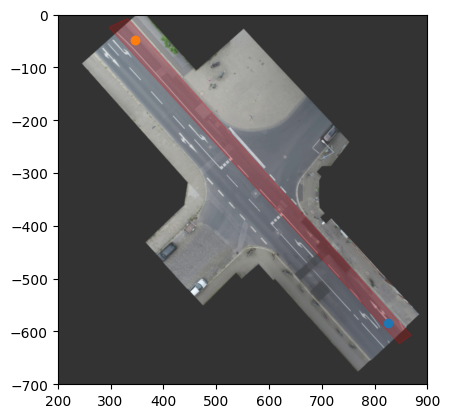

In [8]:
fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)
Drive_Area_visual.plot(color = 'r', alpha = 0.2)
for i in range(len(not_Drive_Area_visual)):
    not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)
plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.scatter(x_EV_initial[0]*real_to_image,x_EV_initial[1]*real_to_image)
plt.scatter(Param["RefPos"][0]*real_to_image,Param["RefPos"][1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()

In [9]:
def plot_ellipsoids(qr, Qr_Inv, ax):
    N = qr.shape[1]
    for i in range(N):
        q = qr[:, i] * real_to_image
        Q_inv_block = Qr_Inv[:, 2*i:2*i+2]
        Q = np.linalg.inv(Q_inv_block) * (real_to_image ** 2)
        vals, vecs = np.linalg.eigh(Q)
        width = 2 * np.sqrt(vals[0])
        height = 2 * np.sqrt(vals[1])
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

        ellipse = Ellipse(
            xy=q, width=width, height=height, angle=angle,
            edgecolor='blue', facecolor='blue', linewidth=2, alpha=0.2
        )
        ax.add_patch(ellipse)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



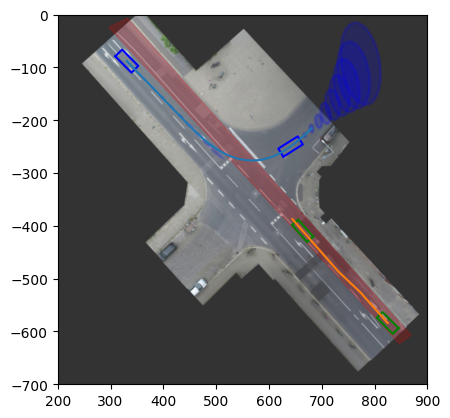

In [10]:
#test mpc
Simulation_time = N_Sam//6
test_polytope = el_estimation_OR(Param)
State_EV_R     = np.zeros((5, Simulation_time+1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = list( )

fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)
half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2

sv = track_id

for i in range(0,Simulation_time):
    track_time = i*6
    x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
    y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
    x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
    y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
    x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
    y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
    yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
    if track_time < sv_lifetime and track_time >= 0:
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    else:
        SV_acc = np.zeros((2,1))
        SV_position = np.zeros((2,1))
        SV_velocity = np.zeros((2,1))
        SV_yaw = np.zeros((1,1))
    U_R, trajectory_planning_k, J_R, Q_list, q_list, Q_visual, q_visual= test_polytope.Return(SV_acc, SV_position, SV_velocity, State_EV_R[:, i])
    X_EV_Planning_R.append(trajectory_planning_k[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k[:, 1]
    
    if i % 20 == 0:
        corners_sv = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])
        rad_yaw_sv = SV_yaw.item()
        rotation_matrix_sv = np.array([
                [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
                [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
            ])
        rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
        rotated_corners_sv[:, 0] += SV_position[0]*real_to_image
        rotated_corners_sv[:, 1] += SV_position[1]*real_to_image
        rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
        plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'b-')

        corners_ev = np.array([
            [-half_length_ev, -half_width_ev],
            [half_length_ev, -half_width_ev],
            [half_length_ev, half_width_ev],
            [-half_length_ev, half_width_ev]
        ])
        rad_yaw_ev = trajectory_planning_k[2,1]
        rotation_matrix_ev = np.array([
                [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
                [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
        rotated_corners_ev[:, 0] += State_EV_R[0, i+1]*real_to_image
        rotated_corners_ev[:, 1] += State_EV_R[1, i+1]*real_to_image
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'g-')
        # plot_ellipsoids(q_list,Q_list, ax)
        plot_ellipsoids(q_visual,Q_visual, ax)
            
Drive_Area_visual.plot(color = 'r', alpha = 0.2)
for i in range(len(not_Drive_Area_visual)):
    not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x*real_to_image, SV_y*real_to_image)
plt.plot(State_EV_R[0]*real_to_image, State_EV_R[1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()

/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


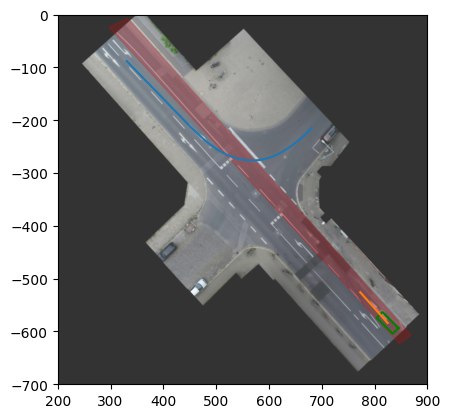

In [13]:
test_polytope = el_estimation_OR(Param)
fig, ax = plt.subplots()
img = mpimg.imread(background_filepath)

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2
Simulation_time = N_Sam//6
frame_length = Simulation_time + 70
sv = track_id

ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
ax.set_xlim([x_lim_0, x_lim_1])
ax.set_ylim([-y_lim_0, -y_lim_1])

State_EV_R = np.zeros((5, frame_length + 1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = []


def draw_vehicle(ax, corners, rotation_matrix, position, color):
    rotated_corners = corners.reshape(4,2) @ rotation_matrix.T
    rotated_corners[:, 0] += position[0]
    rotated_corners[:, 1] += position[1]
    rotated_corners = np.vstack([rotated_corners, rotated_corners[0]]) 
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color)

corners_sv = np.array([
    [-half_length_sv, -half_width_sv],
    [half_length_sv, -half_width_sv],
    [half_length_sv, half_width_sv],
    [-half_length_sv, half_width_sv]
])
corners_ev = np.array([
    [-half_length_ev, -half_width_ev],
    [half_length_ev, -half_width_ev],
    [half_length_ev, half_width_ev],
    [-half_length_ev, half_width_ev]
])

def update(frame):
    ax.clear()
    ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
    ax.set_xlim([x_lim_0, x_lim_1])
    ax.set_ylim([-y_lim_0, -y_lim_1])
    
    global State_EV_R

    track_time = frame*6 - 50
    if track_time < sv_lifetime and track_time >= 0:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    elif track_time < 0:
        SV_acc = np.zeros((2,1))
        SV_position = np.zeros((2,1))
        SV_velocity = np.zeros((2,1))
        SV_yaw = np.zeros((1,1))
    else:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    U_R, trajectory_planning_k, J_R, Q_list, q_list, Q_visual, q_visual = test_polytope.Return(SV_acc,SV_position,SV_velocity, State_EV_R[:, frame])
    X_EV_Planning_R.append(trajectory_planning_k[0:2, 1].reshape(2, 1))
    State_EV_R[:, frame + 1] = trajectory_planning_k[:, 1]

    rad_yaw_sv = SV_yaw.item()
    rotation_matrix_sv = np.array([
        [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
        [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
    ])
    draw_vehicle(ax, corners_sv, rotation_matrix_sv, [SV_position[0]*real_to_image, SV_position[1]*real_to_image], 'b-')

    rad_yaw_ev = trajectory_planning_k[2, 1]
    rotation_matrix_ev = np.array([
        [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
        [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev, [State_EV_R[0, frame + 1]*real_to_image,
                                                    State_EV_R[1, frame + 1]*real_to_image], 'g-')

    # plot_ellipsoids(q_list,Q_list, ax)
    plot_ellipsoids(q_visual,Q_visual, ax)

    ax.plot(SV_x*real_to_image, SV_y*real_to_image)

    #print(trajectory_planning_k.shape)
    ax.plot(trajectory_planning_k[0]*real_to_image,trajectory_planning_k[1]*real_to_image)
    Drive_Area_visual.plot(color='r', alpha=0.2)
    for i in range(len(not_Drive_Area_visual)):
        not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

ani = FuncAnimation(fig, update, frames=range(0, frame_length), interval=100, repeat=False)
#plt.show()
ani.save("../videos/inD_MPC/inD_ellipsoid_simulation.mp4", writer='ffmpeg', fps=15)

In [14]:
from IPython.display import Video

# Specify the full file path
video_path = "../videos/inD_MPC/inD_ellipsoid_simulation.mp4"

# Display the video
Video(video_path, embed=True)